In [1]:
import matplotlib.pyplot as plt
import numpy as np
# from functions import complex_correlation, colorize, show_colormap_image
import os
import json

# for Jupyter lab
#%matplotlib widget
# for Jupyter notebook
# %matplotlib notebook
%matplotlib inline

data_folder = '../Data/'

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
import torch
from functions import showZernikeCoefs
from PyTorchAberrations.aberration_functions import pt_to_cpx, cpx_to_pt, tm_to_pt
from PyTorchAberrations.aberration_models import AberrationModes
from PyTorchAberrations.aberration_functions import conjugate, complex_matmul, normalize

# 1. Display optimized Zernike coefficients from aberration correction results 

## 1.1 Load data from optimization

In [3]:
files = ['TM_17_optimization_results.npz',
         'TM_25_optimization_results.npz',
         'TM_35_optimization_results.npz',
         'TM_50_optimization_results.npz']

data = [np.load(data_folder+f_name, allow_pickle=True) for f_name in files]

labels = [rf'${d["dx"]}\;'+r'\mu m$' for d in data]
Zernike_in = [d['best_Zernike_coeff'][1] for d in data]
Zernike_out = [d['best_Zernike_coeff'][1] for d in data]

## 1.2 Display input Zernike coefficients

/home/spopoff/mycore/Articles/2020/modalTM_MMF/git/article_MMF_disorder/Aberration_correction/functions.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(zernike_names, rotation=40, ha='right')


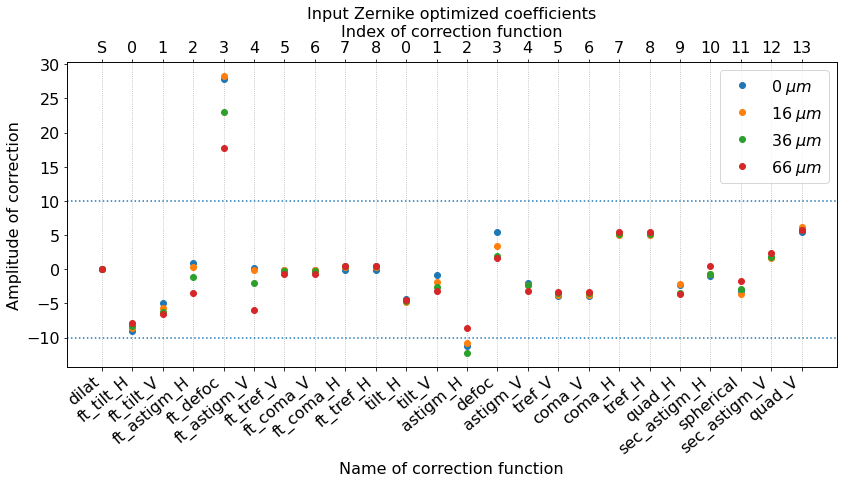

In [4]:
showZernikeCoefs(Zernike_in, labels, title = 'Input Zernike optimized coefficients');
# plt.savefig('comparison_Zernike_in.svg', dpi = 400)

## 1.3 Display output Zernike coefficients

/home/spopoff/mycore/Articles/2020/modalTM_MMF/git/article_MMF_disorder/Aberration_correction/functions.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(zernike_names, rotation=40, ha='right')


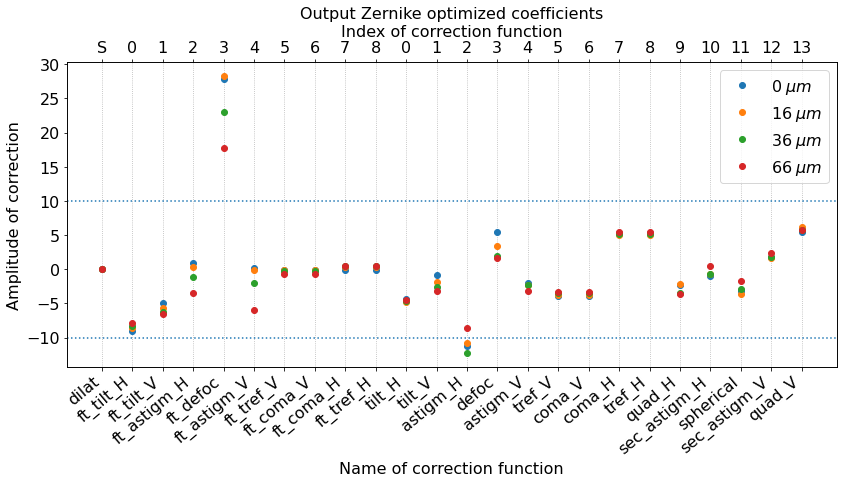

In [5]:
showZernikeCoefs(Zernike_out, labels, title = 'Output Zernike optimized coefficients');
# plt.savefig('comparison_Zernike_out.svg', dpi = 400)

# 2. Use correction from a different deformation for the reconstruction of the mode basis TM 

## 2.1 Load correction from  $\Delta x = 0\mu m$

In [6]:
correction_from_0 = data[0]['model_state_dict'][()]

## 2.2 Load ideal mode bases 

In [7]:
path = os.path.sep.join([data_folder,'conversion_matrices.npz'])
data_dict = np.load(path)
modes_in = data_dict.f.modes_in
nmodes = modes_in.shape[0]
# number of input pixels
m = np.int(np.sqrt(modes_in.shape[1]))
modes_out = data_dict.f.modes_out
# number of output pixels
n = np.int(np.sqrt(modes_out.shape[1]))

# input basis of modes
pt_modes_in = cpx_to_pt(modes_in.reshape((-1,m,m)), 'cpu', torch.float32)
pt_modes_in.requires_grad = False

# output basis of modes
pt_modes_out = cpx_to_pt(modes_out.reshape((-1,n,n)), 'cpu', torch.float32)
pt_modes_out.requires_grad = False

## 2.3 Parameters

In [8]:
# padding coefficient for FFT, float > 0.
# the bigger, the more precise the FFT during the calculations
padding_coeff = 0.05

# list of Zernike polynomials to consider in the Fourier plane (both input and output)
list_zernike_ft = list(range(9))

# list of Zernike polynomials to consider in the direct plane (both input and output)
list_zernike_direct = list(range(14))

# learning rate for the optimizer
learning_rate = 30e-2

# number of epoch to train the model
num_epoch = 300

deformation = 'scaling' # for test, do not modify

## 2.4 Create model using correction from $\Delta x = 0 \mu m$

In [9]:
model = AberrationModes(
    inpoints = m, 
    onpoints = n, 
    padding_coeff = padding_coeff, # if the gpu memory gets full, reduce it to just above 0
    list_zernike_ft = list_zernike_ft,
    list_zernike_direct = list_zernike_direct,
    deformation = deformation
)

In [10]:
model.load_state_dict(correction_from_0)
model.eval()

AberrationModes(
  (abberation_output): Aberration(
    (pad): ComplexZeroPad2d(
      (pad_r): ZeroPad2d(padding=(2, 2, 2, 2), value=0.0)
      (pad_i): ZeroPad2d(padding=(2, 2, 2, 2), value=0.0)
    )
    (deformation): ComplexScaling()
    (zernike_ft): Sequential(
      (0): ComplexZernike()
      (1): ComplexZernike()
      (2): ComplexZernike()
      (3): ComplexZernike()
      (4): ComplexZernike()
      (5): ComplexZernike()
      (6): ComplexZernike()
      (7): ComplexZernike()
      (8): ComplexZernike()
    )
    (zernike_direct): Sequential(
      (0): ComplexZernike()
      (1): ComplexZernike()
      (2): ComplexZernike()
      (3): ComplexZernike()
      (4): ComplexZernike()
      (5): ComplexZernike()
      (6): ComplexZernike()
      (7): ComplexZernike()
      (8): ComplexZernike()
      (9): ComplexZernike()
      (10): ComplexZernike()
      (11): ComplexZernike()
      (12): ComplexZernike()
      (13): ComplexZernike()
    )
  )
  (abberation_input): Aberration(

## 2.5 Compute the mode basis matrices with the model

In [11]:
TM_modes_corr_from_16um = data[1]['TM_modes_after']
TM_pix = data[1]['TM_pix']

corr_from_0 = model(pt_modes_in,pt_modes_out)

pt_modes_out_opt, pt_modes_in_opt = \
    [normalize(corr_from_0[0].reshape((-1,n**2,2)),device = 'cpu').reshape((-1,n,n,2)), 
     normalize(corr_from_0[1].reshape((-1,m**2,2)),device = 'cpu').reshape((-1,m,m,2))]

/opt/miniconda/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/miniconda/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/spopoff/mycore/Articles/2020/modalTM_MMF/git/article_MMF_disorder/Aberration_correction/PyTorchAberrations/aberration_models.py:99: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torc

In [12]:
modes_out_corr = pt_to_cpx(pt_modes_out_opt.detach().cpu()).reshape(nmodes,-1)
modes_in_corr = pt_to_cpx(pt_modes_in_opt.detach().cpu()).reshape(nmodes,-1)

## 2.6 Compute the TM projected on the mode basis with correction from $\Delta x = 0 \mu m$

In [13]:
TM_modes_corr_from_0um = modes_out_corr @ TM_pix @ modes_in_corr.T.conj()

## 2.7 Compare the modes basis TM with correction from $\Delta x = 0 \mu m$ and $\Delta x = 16 \mu m$

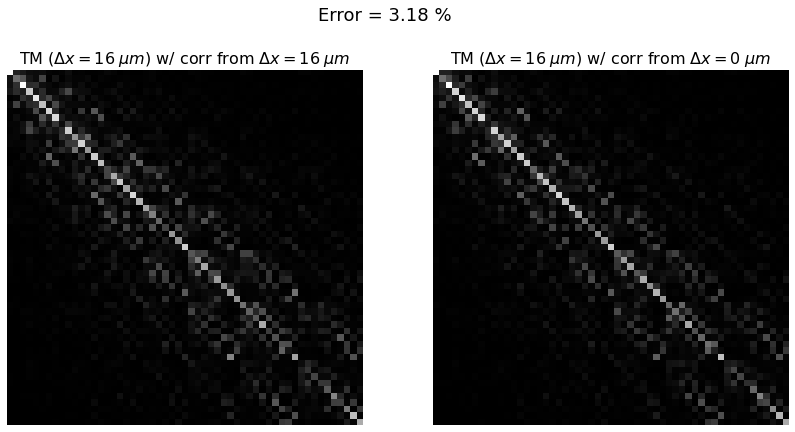

In [15]:
TM1 = TM_modes_corr_from_16um
TM2 = TM_modes_corr_from_0um

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.imshow(np.abs(TM1), cmap = 'gray')
plt.axis('off')
plt.title(r'TM ($\Delta x = 16 \;\mu m$) w/ corr from $\Delta x = 16 \;\mu m$')
plt.subplot(122)
plt.imshow(np.abs(TM2), cmap = 'gray')
plt.axis('off')
plt.title(r'TM ($\Delta x = 16 \;\mu m$) w/ corr from $\Delta x = 0 \;\mu m$')

error = np.linalg.norm(np.abs(TM1) - np.abs(TM2))**2 \
        / np.linalg.norm(np.abs(TM1))**2

plt.suptitle(f'Error = {100*error:.2f} %')

# plt.savefig('comparison_TM_correction.svg', dpi = 400)